In [23]:
from pathlib import Path
import sys
import pypsa
import pandas as pd


def find_repo_root(max_up=6):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / 'README.md').exists() or (p / '.git').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd().resolve()

repo_root = find_repo_root()
src_path = repo_root / 'src/'
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))
print(f"Using src path: {src_path}")
print(f"Repository root: {repo_root}")

import pypsa_simplified as ps

src_path = repo_root / 'scripts/'
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

import geometry as geom

def ifjoin(n: pypsa.Network) -> bool:
    """Helper function to conditionally join network buses."""
    return "[join]" in str(n.name)

def iffloat(n: pypsa.Network) -> bool:
    """Helper function to conditionally join network buses."""
    return "[float]" in str(n.name)

import network_clust as netclust

FIG_PATH = repo_root / 'results' / 'figures'

# T,T

JOIN = True
FLOAT_ = True

Using src path: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/src
Repository root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model


In [24]:
# Load the simplified network
simplified_path = repo_root / "data" / "networks" / f"S+_sEEN{"_join" if JOIN else ""}{"_f" if FLOAT_ else ""}.nc"
n = pypsa.Network(simplified_path)

INFO:pypsa.network.io:Imported network 'Simplified European Electricity Network [join] [float] [simple]' has buses, carriers, lines, links, loads, sub_networks


In [ ]:
# Setup and data preparation
import matplotlib.pyplot as plt
import importlib
importlib.reload(netclust)

# Calculate load weights
load_per_bus = n.loads_t.p_set.sum(axis=0)
bus_loads = load_per_bus.groupby(n.loads.bus).sum()
bus_weights = pd.Series(0.0, index=n.buses.index)
bus_weights.loc[bus_loads.index] = bus_loads

# Analyze country distribution
print("="*70)
print("NETWORK STATISTICS BY COUNTRY")
print("="*70)
country_stats = pd.DataFrame({
    'buses': n.buses.groupby('country').size(),
    'load_TWh': bus_weights.groupby(n.buses.country).sum() / 1e6,
    'load_pct': (bus_weights.groupby(n.buses.country).sum() / bus_weights.sum() * 100).round(2),
})
country_stats = country_stats.sort_values('load_TWh', ascending=False)
print(country_stats.head(20))
print(f"\nTotal countries: {len(country_stats)}")
print(f"Total buses: {len(n.buses)}")
print(f"Total load: {bus_weights.sum()/1e6:.2f} TWh")

# Apply Strategy
n_clusters_target = 300
min_per_country = 3

NETWORK STATISTICS BY COUNTRY
         buses     load_TWh  load_pct
country                              
DE         479  2161.531044     17.98
FR         785  1770.646688     14.73
IT         417  1581.725234     13.16
ES         561  1209.768985     10.06
PL         147   976.116074      8.12
RO          91   510.082350      4.24
NL          38   435.799127      3.62
BE          41   296.187696      2.46
GR          26   280.505793      2.33
SE         132   275.064118      2.29
CZ          40   274.739971      2.29
HU          38   262.842586      2.19
AT          60   258.088610      2.15
PT          88   256.368640      2.13
CH         126   245.099008      2.04
BG          77   166.225096      1.38
DK          34   160.853273      1.34
SK          31   155.975475      1.30
FI          84   144.822708      1.20
NO         217   142.895052      1.19

Total countries: 28
Total buses: 3954
Total load: 12022.23 TWh


## Strategy 5: Optimization-Based Distribution (PyPSA-EUR Method with Gurobi)

**Approach**: Use integer programming to find optimal distribution minimizing deviation from proportional allocation.

This is the "official" PyPSA-EUR method that solves:
```
minimize:   Σ (n_c - L_c * N)²
subject to: Σ n_c = N
            1 <= n_c <= N_c
```

Where:
- `n_c` = clusters allocated to country c (decision variable)
- `L_c` = normalized load weight for country c  
- `N` = total target clusters
- `N_c` = available buses in country c

### How Gurobi Optimization Works

**Gurobi** is a state-of-the-art commercial optimizer that excels at mixed-integer quadratic programming (MIQP). Here's why it's superior for this problem:

1. **Problem Type**: Our objective is **quadratic** (squared terms: n_c²)
   - Linear solvers cannot handle this efficiently
   - Gurobi's quadratic solver finds optimal solutions quickly

2. **Integer Variables**: Cluster counts must be whole numbers
   - Gurobi's branch-and-bound algorithm efficiently searches discrete solutions
   - Guarantees finding the global optimum (not just a local minimum)

3. **Performance**: For 30 countries × 100+ sub-networks:
   - Gurobi: ~0.1-1 second
   - SCIP (open-source): ~1-10 seconds
   - Heuristics: May not find optimal solution

4. **Solution Quality**: Gurobi provides:
   - **Optimality gap**: How close to theoretical best
   - **Bound information**: Certificate of solution quality
   - **Warm starts**: Can use previous solutions for similar problems

### Mathematical Details

The optimization problem in detail:

**Decision Variables:**
```
n_c,s ∈ ℤ⁺   for each (country c, sub_network s)
```

**Objective Function (minimize):**
```
f(n) = Σ_{c,s} (n_c,s - L_c,s × N)²
     = Σ_{c,s} [n²_c,s - 2×n_c,s×L_c,s×N + (L_c,s×N)²]
```

We drop the constant term `(L_c,s×N)²` since it doesn't affect optimization:
```
f(n) ≈ Σ_{c,s} [n²_c,s - 2×n_c,s×L_c,s×N]
```

**Constraints:**
```
1. Total clusters:     Σ_{c,s} n_c,s = N
2. Physical bounds:    1 ≤ n_c,s ≤ N_c,s   (available buses)
3. Integer:            n_c,s ∈ ℤ⁺
```

**Why this objective?**
- Minimizing squared deviations ensures each country gets close to its "fair share" (L_c × N)
- Squared terms penalize large deviations more than small ones
- Creates balanced distribution while respecting physical constraints

### Focus Weights - Advanced Usage

Focus weights allow you to override proportional allocation:

```python
focus_weights = {
    'PL': 0.15,  # Poland gets 15% of total clusters
    'ES': 0.12,  # Spain gets 12%
    'RO': 0.08,  # Romania gets 8%
}
```

**How it works:**
1. Specified countries get **fixed percentage** of N clusters
2. Remaining countries share **(1 - sum of focus_weights)** proportionally by load
3. Total focus_weights must be ≤ 1.0

**Example**: N=250 clusters, focus_weights above:
- Poland: 0.15 × 250 = 37-38 clusters (fixed)
- Spain: 0.12 × 250 = 30 clusters (fixed)  
- Romania: 0.08 × 250 = 20 clusters (fixed)
- Others: Share remaining (1 - 0.35) × 250 = 162 clusters by load

This is extremely powerful for ensuring peripheral countries are well-represented!

### Requirements

**Software:**
- `linopy` package: `pip install linopy`
- Gurobi solver: Academic license (FREE) or commercial

**Installing Gurobi (Academic):**
```bash
# 1. Get FREE academic license: https://www.gurobi.com/academia/
# 2. Install Gurobi
conda install -c gurobi gurobi

# 3. Activate license (after downloading gurobi.lic)
# Place license file in home directory OR set environment variable:
export GRB_LICENSE_FILE=~/gurobi.lic
```

**Alternative: Open-Source SCIP:**
```bash
conda install scip
# Then use: solver_name='scip'
```

### Gurobi vs. SCIP Performance

| Aspect | Gurobi | SCIP (open-source) |
|--------|--------|-------------------|
| **Speed** | ⭐⭐⭐⭐⭐ (10-100x faster) | ⭐⭐⭐ Good |
| **Solution Quality** | ⭐⭐⭐⭐⭐ Guaranteed optimal | ⭐⭐⭐⭐ Very good |
| **Quadratic Problems** | ⭐⭐⭐⭐⭐ Native support | ⭐⭐⭐ Acceptable |
| **License** | Academic: FREE, Commercial: $$$ | FREE (ZIB) |
| **Support** | ⭐⭐⭐⭐⭐ Commercial | ⭐⭐⭐ Community |

**Recommendation**: Use Gurobi for research if you have academic access. The performance difference is substantial for larger problems.

In [26]:
try:
    print(f"Strategy 5: Optimization-Based Distribution (PyPSA-EUR)")
    print(f"Target clusters: {n_clusters_target}")
    print(f"Attempting to use Gurobi solver...")
    
    # Try with focus weights for underrepresented regions
    focus_opt = {
        'PL': 0.15,
        'ES': 0.12,
        'RO': 0.08,
        'SE': 0.08,
        'PT': 0.06,
        'GR': 0.06,
    }
    
    n_clusters_s5 = netclust.distribute_n_clusters_to_countries(
        n, 
        n_clusters_target, 
        bus_weights,
        focus_weights=focus_opt,
        solver_name='gurobi'
    )
    
    print(f"\nOptimization successful!")
    print(f"\nCluster allocation by country:")
    country_clusters = n_clusters_s5.groupby(level=0).sum().sort_values(ascending=False)
    print(country_clusters.head(20))
    
    # Create busmap and cluster
    busmap_s5 = netclust.busmap_for_n_clusters(
        n, n_clusters_s5, bus_weights, algorithm="kmeans"
    )
    clustering_s5 = netclust.clustering_for_n_clusters(n, busmap_s5)
    n_s5 = clustering_s5.n
    
    print(f"\nClustering complete:")
    print(f"  Buses: {len(n.buses)} → {len(n_s5.buses)}")
    print(f"  Countries represented: {len(n_s5.buses.country.unique())}")
    
    # Add to comparison
    strategy_results = busmap_s5
    
except ImportError as e:
    print(f"⚠️  Cannot run Strategy 5: Missing dependency")
    print(f"   Required: linopy package")
    print(f"   Install: pip install linopy")
    print(f"   Error: {e}")
except Exception as e:
    print(f"⚠️  Strategy 5 failed: {e}")
    print(f"   This is expected if you don't have Gurobi installed")
    print(f"   Falling back to simpler methods is fine!")
    print(f"\n   To use optimization-based distribution:")
    print(f"   1. Install linopy: pip install linopy")
    print(f"   2. Install a solver: conda install -c gurobi gurobi (academic license)")
    print(f"   3. Or use open-source solver: conda install scip")

INFO:network_clust:Distributing 200 clusters across countries using gurobi
INFO:network_clust:Applying focus weights for 6 countries
INFO:network_clust:Using custom focus weights for determining number of clusters.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
 - TimeLimit: 60
 - MIPGap: 0.01
INFO:linopy.io: Writing time: 0.01s


Strategy 5: Optimization-Based Distribution (PyPSA-EUR)
Target clusters: 200
Attempting to use Gurobi solver...
Set parameter Username
Set parameter LicenseID to value 2755728
Academic license - for non-commercial use only - expires 2026-12-16
Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-fkum1hfw.lp
Reading time = 0.00 seconds
obj: 1 rows, 95 columns, 95 nonzeros
Set parameter LogToConsole to value 0


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 95 primals, 0 duals
Objective: -1.75e+03
Solver model: available
Solver message: 2

INFO:network_clust:Optimization successful. Cluster distribution:
country  sub_network
AT       0              2
BE       0              3
         20             1
         53             1
BG       0              1
                       ..
SE       39             1
         45             1
         6              1
SI       0              1
SK       0              1
Name: n, Length: 95, dtype: int64
INFO:network_clust:Creating busmap using kmeans algorithm



Optimization successful!

Cluster allocation by country:
country
DE    27
FR    23
IT    22
PL    16
GB    13
PT    12
ES    11
SE     9
DK     9
RO     7
NL     7
GR     7
NO     5
BE     5
FI     4
EE     3
CZ     3
AT     2
HU     2
LT     2
Name: n, dtype: int64


INFO:network_clust:Created busmap with 200 unique clusters
INFO:network_clust:Performing network clustering
INFO:network_clust:Clustering complete:
  Buses: 3954 -> 200
  Lines: 5485 -> 253
  Links: 28 -> 28



Clustering complete:
  Buses: 3954 → 200
  Countries represented: 28


In [27]:
n_s5.name = n.name + " [gurobi]"

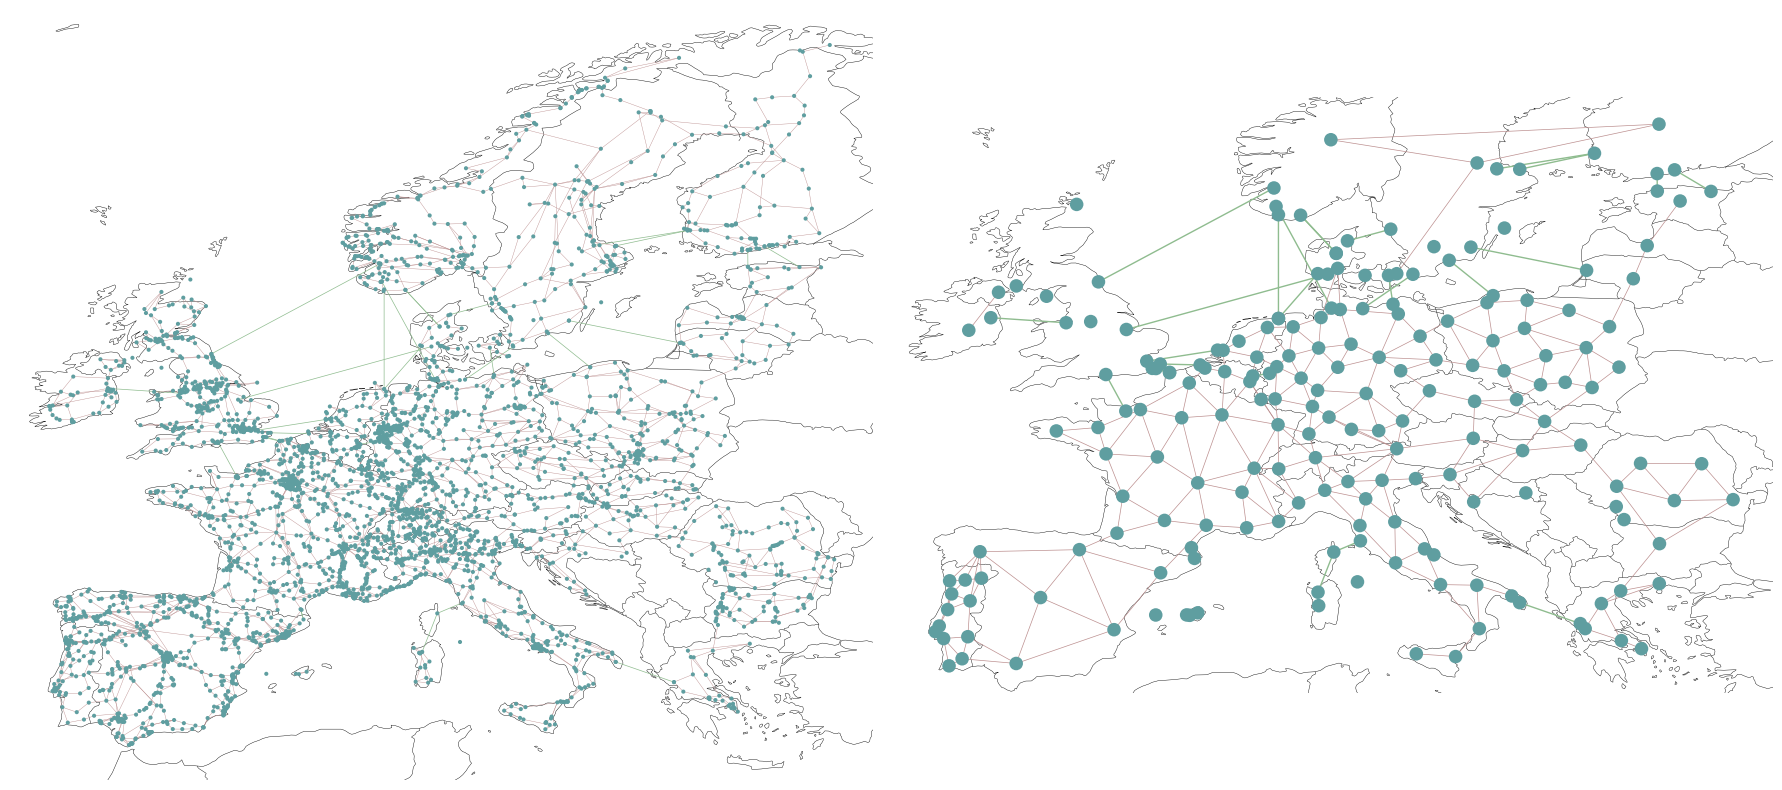


Clustering summary:
  Bus reduction: 3954 → 200 (94.9% reduction)
  Line reduction: 5485 → 253 (95.4% reduction)
  Computational speedup: ~390.9x faster


In [28]:
import cartopy.crs as ccrs

# Step 6: Visualize network topology before/after clustering

fig = plt.figure(figsize=(18, 8))
proj = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
ax2 = fig.add_subplot(1, 2, 2, projection=proj)

# Original simplified network
ax1.set_title(f'Simplified Network ({len(n.buses)} buses)', fontsize=14, fontweight='bold')

n.plot(
    ax=ax1,
    bus_sizes=0.01,
    line_widths=0.3,
    link_widths=0.5,
    margin=0.05,
)

# Clustered network
ax2.set_title(f'Clustered Network ({len(n_s5.buses)} buses)', fontsize=14, fontweight='bold')
n_s5.plot(
    ax=ax2,
    bus_sizes=0.1,  # Larger since fewer buses
    line_widths=0.5,
    link_widths=1.0,
    margin=0.05,
)

plt.tight_layout()
plt.savefig(FIG_PATH / f'network_clustering_{"join" if JOIN else "nojoin"}_{"float" if FLOAT_ else "nofloat"}_gurobi_{n_clusters_target}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClustering summary:")
print(f"  Bus reduction: {len(n.buses)} → {len(n_s5.buses)} ({100 * (1 - len(n_s5.buses)/len(n.buses)):.1f}% reduction)")
print(f"  Line reduction: {len(n.lines)} → {len(n_s5.lines)} ({100 * (1 - len(n_s5.lines)/len(n.lines)):.1f}% reduction)")
print(f"  Computational speedup: ~{(len(n.buses)/len(n_s5.buses))**2:.1f}x faster")

In [29]:
# Detect parameters from network name
JOIN = "[join]" in n.name or "_join" in n.name
FLOAT_ = "[float]" in n.name or "_f" in n.name

# Build save path
strategy_name = "gurobi"  # or "focus", "hybrid", etc.
save_name = f"C+_sEEN{'_join' if JOIN else ''}{'_f' if FLOAT_ else ''}_cl{n_clusters_target}_{strategy_name}.nc"
save_path = repo_root / "data" / "networks" / "clustered" / save_name

n_s5.export_to_netcdf(save_path)
print(f"Saved: {save_path}")

INFO:pypsa.network.io:Exported network 'Simplified European Electricity Network [join] [float] [simple] [gurobi]' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/clustered/C+_sEEN_join_f_cl200_gurobi.nc contains: links, lines, loads, sub_networks, buses, carriers


Saved: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/clustered/C+_sEEN_join_f_cl200_gurobi.nc
